In [2]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, LinearAlgebra

In [3]:
# Input signal 1/2
GLN = [-69.30526315789474 259210.52631578967;
-39.98640350877193 128947.36842105305;
-0.149561403508784 160526.3157894737;
0.7504385964912217 2260526.3157894732;
2.060526315789474 551315.789473684;
4.986403508771957 1384210.5263157894;
15.04956140350879 452631.5789473681;
35.19692982456144 278947.3684210526]

# Input signal 2/2
alpha_KG = [-69.1822094691535 757981.241276999;
-40.08608321377332 3916093.2665749225;
0.02869440459110706 2755102.040816326;
0.37302725968436334 374169.17986706924;
1.9225251076040024 265413.4824661575;
5.193687230989951 428864.2286182763;
15.007173601147798 613094.0180950426;
35.15064562410328 512195.1219512196]


# Output signal 1/4
GS = [-101.42291847737759 20384.542004960465;
-69.45971918964945 21119.072350709095;
-50.34850444109978 33766.773366120455;
-40.36503932334175 36792.65681639921;
-15.4415308191833 35790.60055540246;
-0.2163667069439441 39585.56801560215;
0.6828058423250809 25036.991499374642;
1.5166161434153764 22449.706399847375;
2.46560532508002 28784.686155215913;
5.767635441177532 24513.174909376135;
15.093944982652516 27798.528819451807;
34.91354517767934 30811.693129544445]

# Output signal 2/4
GS_AMP = [-101.32081204643899 1699.0651431963197;
-69.677357810612 946.9399868568944;
-50.33083896861906 533.9919021474198;
-40.333594782326045 1038.305810527214;
-15.411499515966057 294.87206664829864;
-0.005440965524059038 986.15733576411;
0.09454560871685658 12688.614249676728;
1.5734989648033206 12040.150085854206;
2.419321787180536 7254.573590825261;
4.681208883612783 13329.234943717805;
14.874539814441874 7949.674601996914;
34.905419060338204 2298.7726029720434]

# Output signal 3/4
PII = [-100.76322958187433 571.2230990278717;
-69.08256359498955 469.27525484344596;
-49.78293827241711 354.62037372054965;
-39.739310629416224 126.08657949112057;
-14.817909162403069 99.32241097299493;
0.20554929265804844 125.00112134106439;
1.0010734971787087 1354.327329922463;
1.9684768600057794 1145.6053896136905;
2.4428489837659697 956.4620642842406;
5.616333902476242 1295.5062630636235;
14.866231486659046 1353.9505593249226;
34.999775731787196 1317.5338869269572]

# Output signal 4/4
PII_UMP = [-100.56515589631033 871.2177165907642;
-68.9921386515799 1291.0119280786794;
-49.67277772627915 1355.7043367491874;
-39.759763890425546 1440.2175700688654;
-14.775567323822372 1984.1038690752075;
0.15351906728346876 1152.1764482493622;
0.3939345914281489 1836.952523914467;
1.0868336617616592 633.6728255701644;
2.0628489239610985 503.21152080760476;
5.36622999153758 522.6869724090293;
15.134276854623351 789.8128407007932;
34.961381013752145 968.6218867834257];

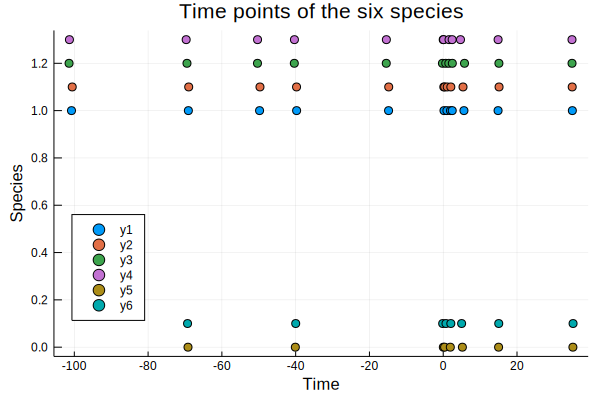

In [4]:
scatter(PII[:,1], ones(12), legend =:bottomleft, title = "Time points of the six species", xlab = "Time", ylab = "Species")
scatter!(PII_UMP[:,1], ones(12).+0.1)
scatter!(GS[:,1], ones(12).+0.2)
scatter!(GS_AMP[:,1], ones(12).+0.3)
scatter!(alpha_KG[:,1], zeros(8))
scatter!(GLN[:,1], zeros(8).+0.1)

In [13]:
# Observed data: Only take timepoints where all species are measured into account
ind_input_species = [2,4,6,8,9,10,11,12]
ode_data = transpose(hcat(alpha_KG[:,2], PII[ind_input_species,2], PII_UMP[ind_input_species,2]));

In [14]:
u0 = ode_data[:,1]
tspan = (0.,1.)
t = GS[ind_input_species,1]
t = t.+abs(t[1])
t = t./t[end]
species = ["GLN","alpha_KG", "GS", "GS-AMP", "PII", "PII-UMP"]
colors = ["red", "red", "blue", "blue", "lightblue", "lightblue"];

In [15]:
test = [6,5,4]
plot(ode_data[test[1],:], ode_data[test[2],:], ode_data[test[3],:], xlab = species[test[1]], ylab = species[test[2]], zlab  = species[test[3]], label = "Path in state space", grid = "off")
scatter!(ode_data[test[1],:], ode_data[test[2],:], ode_data[test[3],:], label = "Observations", color = "blue")

BoundsError: BoundsError: attempt to access 3×8 Transpose{Float64,Array{Float64,2}} at index [6, Base.Slice(Base.OneTo(8))]

In [16]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()), n_epochs)
    count_epochs = 0
    return saver(losses, l2s, times, count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
    end;

In [17]:

scatter(t, log.(ode_data[1,:]), grid = "off", xlab = "time", ylab = "Abundance", label = species[1], xlim = (0,1.5), color = colors[1], legend = :topright)
plot!(t, log.(ode_data[1,:]), label = species[1], color = colors[1])

scatter!(t, log.(ode_data[2,:]), label = species[2], color = colors[2])
plot!(t, log.(ode_data[2,:]), label = species[2], color = colors[2])

scatter!(t, log.(ode_data[3,:]), label = species[3], color = colors[3])
plot!(t, log.(ode_data[3,:]), label = species[3], color = colors[3])

scatter!(t, log.(ode_data[4,:]), label = species[4], color = colors[4])
plot!(t, log.(ode_data[4,:]), label = species[4], color = colors[4])

scatter!(t, log.(ode_data[5,:]), label = species[5], color = colors[5])
plot!(t, log.(ode_data[5,:]), label = species[5], color = colors[5])

scatter!(t, log.(ode_data[6,:]), label = species[6], color = colors[6])
plot!(t, log.(ode_data[6,:]), label = species[6], color = colors[6])

BoundsError: BoundsError: attempt to access 3×8 Transpose{Float64,Array{Float64,2}} at index [4, Base.Slice(Base.OneTo(8))]

In [18]:
# SingularException(3)
dudt = Chain(Dense(3,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,3))
ps = Flux.params(dudt)
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_, x, tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
println("t is ", t)
println("tspan is ", tspan)
println("u0 is ", u0)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff = false), reltol = 1e-7, abstol = 1e-9)

t is [0.0, 0.278756, 0.66342, 0.680024, 0.689116, 0.720753, 0.810108, 1.0]
tspan is (0.0, 1.0)
u0 is [7.57981e5, 469.275, 1291.01]


SingularException: SingularException(3)

In [ ]:
#  loss function
two_stage_loss_fct() = loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 3000
verify = 100 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.1)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end;

In [ ]:
pred = n_ode(u0)
println(length(Flux.data(pred[1,:])))
println(length(t))
plot(t, Flux.data(pred[1,:]))

In [ ]:
pred = n_ode(u0)
scatter(t, log.(ode_data[1,:]), label = string("Observation: ", species[1]), grid = "off")
scatter!(t, log.(ode_data[2,:]), label = string("Observation: ", species[2]))
scatter!(t, log.(ode_data[3,:]), label = string("Observation: ", species[3]))
scatter!(t, log.(ode_data[4,:]), label = string("Observation: ", species[4]))
scatter!(t, log.(ode_data[5,:]), label = string("Observation: ", species[5]))
scatter!(t, log.(ode_data[6,:]), label = string("Observation: ", species[6]))
plot!(t, log.(Flux.data(pred[1,:])), label = string("Prediction: ", species[1]))
plot!(t, log.(Flux.data(pred[2,:])), label = string("Prediction: ", species[2]))
plot!(t, log.(Flux.data(pred[3,:])), label = string("Prediction: ", species[3]))
plot!(t, log.(Flux.data(pred[4,:])), label = string("Prediction: ", species[4]))
plot!(t, log.(Flux.data(pred[5,:])), label = string("Prediction: ", species[5]))
plot!(t, log.(Flux.data(pred[6,:])), label = string("Prediction: ", species[6]))

In [ ]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
scatter!(t, ode_data[3,:], label = string("Observation: ", species3))
scatter!(t, ode_data[4,:], label = string("Observation: ", species4))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species3))
plot!(t, Flux.data(pred[4,:]), label = string("Prediction: ", species4))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
#scatter!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s

In [ ]:
opt1 = ADAM(0.000001)
sa = saver(n_epochs)
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s